# 1. Sarsa Algorithm and the OpenAI Gym's Taxi Environment

## Introduction

Tabular methods are suitable for small and discrete state space and discrete action space environments. So, the state-action function (Q) can be represented by a table of values. For large state space environments, we prefer to use approximation methods such as neural networks. However, the simplicity of tabular methods' implementation is helpful to demonstrate RL method's functionality. In this notebook, we train a SARSA agent for OpenAI's Taxi Gym environment .

## Goal

In this notebook, we are going to resolve the <a href="https://gym.openai.com/envs/Taxi-v2/">Taxi environment</a> (an example originally proposed by Tom Dietterich) with the SARSA and Q-Learning algorithms. Once we implement SARSA, implementing Q-Learning and many others (e.g., Expected SARSA, Double Q-learning, etc.) would be easy. We usually need to change the core update method.

## The Taxi Environment

Here is a description of the taxi environment from the [docstring](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py).

The Smartcab's job is to pick up the passenger in a simplified gridworld like environment at one location and drop them off in another ([Taxi, OpenAI Gym](https://gym.openai.com/envs/Taxi-v2/)). Here are a few things that we'd love our Smartcab to take care of:

- Drop off the passenger to the right location.
- Save passenger's time by taking minimum time possible to drop off
- Take care of passenger's safety and traffic rules

<center><img style="align: center;" src="https://raw.githubusercontent.com/FredAmouzgar/comp8220_ML/main/2021S2/images/Taxi_Env.png" width=400></center>

__State__: Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or `[(0,0), (0,4), (4,0), (4,3)]` in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

__Actions__: The agent is allowed to perform six possible actions:

1. south
2. north
3. east
4. west
5. pickup
6. dropoff

Notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

## Working with the OpenAI Library

Here are some of OpenAI Gym's methods to initialize and interact with the environments.

#### 1- Creating a new environment and assigning it to a variable

```python
# See the list of all the available environments by running this: gym.envs.registry.all()
env = gym.make(ENV_NAME)
```
OR if you want to override the horizon of some of the environments and make it infinite (we need this for week 12). MountainCar's horizon is by default 200 steps.

```python
env = gym.make(ENV_NAME).env
```

#### 2- Reseting an Environment
```python
state = env.reset()
```
This will generate the first state, and can be processed by the agent.

#### 3- Taking a Step
```python
new_state, reward, done, info = env.step(action)
```
The environment processes the action chosen by the agent. A tuple will be generated consisting of the new state, the received reward, the end status of the game, and some extra information.

#### 4- Rendering the Environment

```python
env.render()
```
In Colab notebooks, this doesn't work properly. So, we provided a wrapper function called `display_status()` that makes the rendering, Colab/Jupyter friendly.

#### 5- Checking out the number states and actions available in this environment:

```python
env.action_space.n  # For the Taxi environment = 6 (up, down, left, right, pickup, dropoff)
env.observation_space.n  # For the Taxi environment = 500 (for complex environments this number is either too large or it can be practically infinite)
```

### Installations

In [1]:
!pip -q install gym numpy matplotlib

### Setting up the environment

In [2]:
import gym

# Finding the Taxi environment
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##


print("Environment Name:", env_name)
env = gym.make(env_name)
env.reset()
env.render()

Environment Name: Taxi-v3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## The SARSA Algorithm
<p> </p><br>
<center><img style="align: center;" src="https://raw.githubusercontent.com/FredAmouzgar/comp8220_ML/main/2021S2/images/SARSA_algorithm.png" width=900></center>

In [3]:
import numpy as np

class Sarsa_Agent:
    def __init__(self, states_n, actions_n, alpha=0.1, epsilon=1,
                 epsilon_decay_factor=0.0005, epsilon_final_value=0.1,
                 gamma=0.95, epsilon_decay=True):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.all_actions = np.arange(actions_n)
        """
        TODO 1:
          - Initialize Q as a 2D numpy array representing agent's state-action value function.
        """
        self.Q = np.zeros(shape=(self.states_n, self.actions_n)) # Your Code Here (1 line)
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor
        self.epsilon_final_value = epsilon_final_value

    def act(self, state, exploration=True):
        # epsilon greedy
        """
        TODO 2: if exploration is allowed, do ε-greedy, otherwise, pick the best action
        - For ε-greedy, generate a random number in [0,1) from a function like np.random.rand() and compare it to self.epsilon
            - If the random number is less than ε, act randomly (pick one of the available actions in self.all_actions)
            - Otherwise, act greedily (choose the best action in the state). You can use the np.argmax() method in this process.
        """
        # Your Code Here (~ 7 lines)
        if exploration:
          if np.random.rand() < self.epsilon:
            action = np.random.choice(self.all_actions)
          else:
            action = np.argmax(self.Q[state, :])
        else:
          action = np.argmax(self.Q[state, :])
        return action

    def decay_epsilon(self):
        """
        Todo 3:
            - If self.epsilon is larger than our final value, subtract it from the decay_factor (find these variables in the __init__ method).
            - Otherwise, set it to the final value intended for ε.
        """
        # Your Code Here (~ 4 lines)
        if self.epsilon > self.epsilon_final_value:
          self.epsilon -= self.epsilon_decay_factor
        else:
          self.epsilon = self.epsilon_final_value
          
    def update(self, new_s, r, s, a, done):
        """
        TODO 4: After each timestep we update the agent using the SARSA update rule
            1- Take a new action and save it in the self.new_a variable, as we need it to update our Q function.
            2- Make sure all the elements (s, a, self.new_a, new_s) are integer, if not cast them with int()
            3- Update Q(s, a) with the SARSA update rule (Q(s,a) = Q(s,a) + α (r + γ Q(s',a') - Q(s,a)))
            3'- Take care of the update rule for the terminal state (max(Q(s',:)) is zero: Q(s,a) = Q(s,a) + α (r - Q(s,a)))
            4- If done is True, decay the epsilon with the decay_epsilon method
            5- Return the new action
        """
        # Your Code Here
        self.new_a = self.act(new_s)
        s, a, self.new_a, new_s = int(s), int(a), int(self.new_a), int(new_s)
        self.Q[s,a] += self.alpha * (r + self.gamma * (1 - int(done)) * self.Q[new_s, self.new_a] - self.Q[s, a])
        if done:
          self.decay_epsilon()
        return self.new_a # Your Code Here

## Util functions

In [4]:
# Utils - PLEASE DO NOT MODIFY THIS CELL
from time import sleep

def display_status(episode, return_episode, epsilon, stime, returns, avg_returns, stds):
    """
    A helper function for displaying agent's behavior
    """
    clear_output(wait=True)
    etime = time()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    axes.set_title("Episode:" + str(episode) + " - Return:"+str(return_episode)\
              + " - Epsilon:" + str(epsilon)[:5] + " - elapsed time: " + str(etime - stime)[:4])
    axes.set_xlabel("Episode")
    axes.set_ylabel("Returns (sum of rewards in each episode)")
    axes.plot(list(range(len(returns))),returns, alpha=0.4, color="blue")
    axes.plot(list(range(len(returns))),avg_returns, linewidth=3, color="orange")
    axes.fill_between(list(range(len(returns))), np.array(avg_returns)+np.array(stds), np.array(avg_returns)-np.array(stds), color="red", alpha=0.7)
    axes.legend(['Actual Returns', 'Average Returns (last 100)', 'STD of Returns (last 100)'])
    plt.show()
    
def taxi_print_frames(frames, wait_btw_frames, episode):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Passenger #: {episode + 1}")
        print("-----------")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(wait_btw_frames)
        
def play_taxi(env, agent, passengers=2, wait_btw_frames=1, tolerance=20):
    for episode in range(passengers):
        state = env.reset()
        frames = []
        done = False
        step = 0
        while not done:
            action = agent.act(state, exploration=False)
            new_state, reward, done, _ = env.step(action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            step += 1
            state = new_state
            if step >= tolerance:
                print(f"No Done in {step} steps.")
                break
        taxi_print_frames(frames, wait_btw_frames=wait_btw_frames, episode=episode)

## The Train Loop
<p> </p><br>
<center><img style="align: center;" src="https://raw.githubusercontent.com/FredAmouzgar/comp8220_ML/main/2021S2/images/MDP_loop.jpeg" width=900></center>

In [5]:
# Making sure we know our Taxi environment version
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##

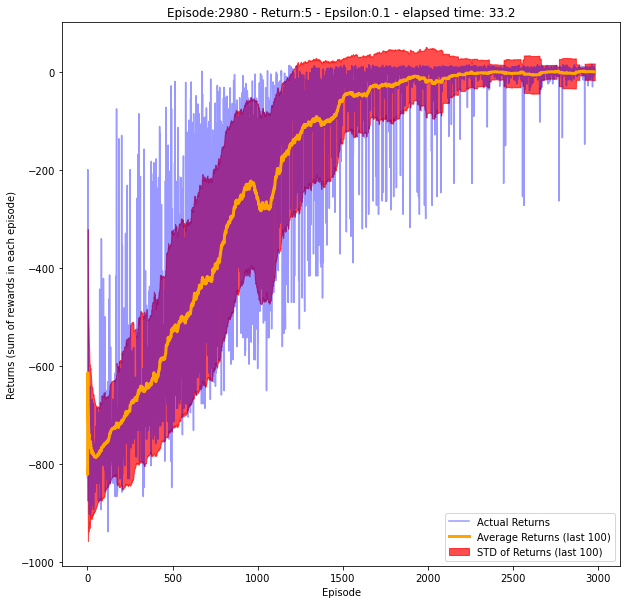

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make(env_name) # Creating the environment
agent = Sarsa_Agent(env.observation_space.n, env.action_space.n) # Initializing the agent
EPISODES = 3000 # Training the agent for 3000 episodes
DISPLAY_RESULTS_INTERVAL = 20

returns = []
avg_returns_sarsa = []
stds_sarsa = []
stime = time()

for episode in range(EPISODES):
    state = env.reset()
    action = agent.act(state)
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        """
        TODO 5:
        1- Take a step in the environment using the "action" variable and the step method from the env variable -> env.step(action)
        2- The step method returns a tuple consists of the new state, reward, done and info. Save them in separate variables.
        3- Add the reward we got as a result of the action to the return_episode variable.
        4- Update the agent with the right parameters.
        5- The update method returns the new action save it in the new_action varible.
        """
        # Your Code Here
        new_state, reward, done, info = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state, reward, state, action, done)

        state, action = new_state, new_action
        step_n += 1
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns_sarsa.append(avg)
            
            std = np.array(returns[-100:]).std() if len(returns) > 100 else np.array(returns[-len(returns):]).std()
            stds_sarsa.append(std)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                clear_output(wait=True)
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns_sarsa, stds_sarsa)

## Watch a smart SARSA self-driving cab:
Note: You can change the number of `passengers` if you want to move more than 3. Change the `wait_btw_frames` if you want to see the game running faster or slower.

In [7]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 16
State: 16
Action: 5
Reward: 20


# 2. Q-Learning Algorithm and the OpenAI Gym's Taxi Environment

## The Q-Learning Algorithm
<p> </p><br>
<center><img style="align: center;" src="https://raw.githubusercontent.com/FredAmouzgar/comp8220_ML/main/2021S2/images/qlearning.png" width=900></center>

In [8]:
import numpy as np

class Qlearning_Agent:
    def __init__(self, states_n, actions_n, alpha=0.1, epsilon=1,
                 epsilon_decay_factor=0.0005, epsilon_final_value=0.1,
                 gamma=0.95, epsilon_decay=True):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.all_actions = np.arange(actions_n)
        """
        TODO 6:
          - Initialize Q as a 2D numpy array representing agent's state-action value function.
        """
        self.Q = np.zeros(shape=(self.states_n, self.actions_n)) # Your Code Here
        #self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor
        self.epsilon_final_value = epsilon_final_value

    def act(self, state, exploration=True):
        # epsilon greedy
        """
        TODO 7: if exploration is allowed, do ε-greedy, otherwise, pick the best action
        - For ε-greedy, generate a random number in [0,1) from a function like np.random.rand() and compare it to self.epsilon
            - If the random number is less than ε, act randomly (pick one of the available actions in self.all_actions)
            - Otherwise, act greedily (choose the best action in the state). You can use the np.argmax() method in this process.
        """
        # Your Code Here (~ 7 lines)
        if exploration:
          if np.random.rand() < self.epsilon:
            action = np.random.choice(self.all_actions)
          else:
            action = np.argmax(self.Q[state, :])
        else:
          action = np.argmax(self.Q[state, :])
        return action

    def decay_epsilon(self):
        """
        Todo 8:
            - If self.epsilon is larger than our final value, subtract it from the decay_factor (find these variables in the __init__ method).
            - Otherwise, set it to the final value intended for ε.
        """
        # Your Code Here (~ 4 lines)
        if self.epsilon > self.epsilon_final_value:
          self.epsilon -= self.epsilon_decay_factor
        else:
          self.epsilon = self.epsilon_final_value
          

    def update(self, new_s, r, s, a, done):
        """
        *TODO 9: *** DIFFERENT FROM SARSA ***
          After each timestep we update the agent using the Q-learning update rule
            1- Make sure all the elements (s, a, self.new_a, new_s) are integer, if not cast them with int()
            3- Update Q(s, a) with the Q-learning update rule (Q(s,a) = Q(s,a) + α (r + γ max Q(s',:) - Q(s,a)))
            3'- Take care of the update rule for the terminal state (max(Q(s',:)) is zero: Q(s,a) = Q(s,a) + α (r - Q(s,a)))
            4- If done is True, decay the epsilon with the decay_epsilon method
            5- It DOES NOT return anything (like a new action). 
        """
        # Your Code Here
        s, a, new_s = int(s), int(a), int(new_s)
        self.Q[s, a] += self.alpha * (r + self.gamma * (1 - int(done)) * np.max(self.Q[new_s,:]) - self.Q[s, a])
        if done:
          self.decay_epsilon()

## The Train Loop

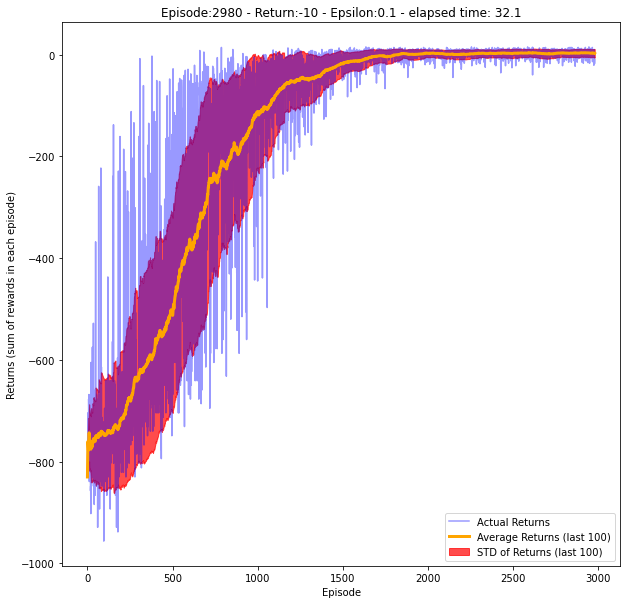

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make(env_name) # Creating the environment
agent = Qlearning_Agent(env.observation_space.n, env.action_space.n) # Initializing the agent
EPISODES = 3000 # Training the agent for 3000 episodes
DISPLAY_RESULTS_INTERVAL = 20

returns = []
avg_returns_qlearning = []
stds_qlearning = []
stime = time()

for episode in range(EPISODES):
    state = env.reset()
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        """
        TODO 10:
        1- Take an action using agent's act method and save it.
        2- Take a step in the environment using the action variable and the step method from the env variable.
        3- The step method returns a tuple consists of the new state, reward, done and info. Save them in separate variables.
        4- Add the reward we got as a result of the action to the return_episode variable.
        5- Update the agent with the right parameters.
        """
        # Your Code Here
        action = agent.act(state)
        new_state, reward, done, info = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state, reward, state, action, done)
        
        state = new_state
        step_n += 1
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns_qlearning.append(avg)
            
            std = np.array(returns[-100:]).std() if len(returns) > 100 else np.array(returns[-len(returns):]).std()
            stds_qlearning.append(std)
            
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                clear_output(wait=True)
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns_qlearning, stds_qlearning)

## Watch a smart Q-Learning self-driving cab:
Note: You can change the number of `passengers` if you want to move more than 3. Change the `wait_btw_frames` if you want to see the game running faster or slower.

In [10]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 13
State: 16
Action: 5
Reward: 20


# How the learning happened?

The Sarsa and Q-Learning agents are implementing a __tabular method__ which means that they're updating a table of values iteratively. As said before, this table is called Q-table. After the training, the agent knows exactly which actions are the best in almost all possible states.

In __Approximation methods__ and __Deep Reinforcement Learning__, this table is replaced by a linear model or a [neural network](https://www.nature.com/articles/nature14236). A well-designed network can learn much more complex tasks, generalizes, and thus responds better to unseen situations.

__Take a look at the Pigoen Pong Experiment__ (special thanks go to <a href="https://complexity-in-action.github.io/people/patricknalepka.html">Dr. Patrick Nalepka</a>): Artificial agents follow the same process. __We'll show an agent with neural network on week 12.__

In [11]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/vGazyH6fQQ4" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/fred/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/pong.gif" width=200>

# More Questions:

Q1: Compare the performance of SARSA and the Q-learning algorithms. Which one outperforms the other? Can you think of a reason for this difference?

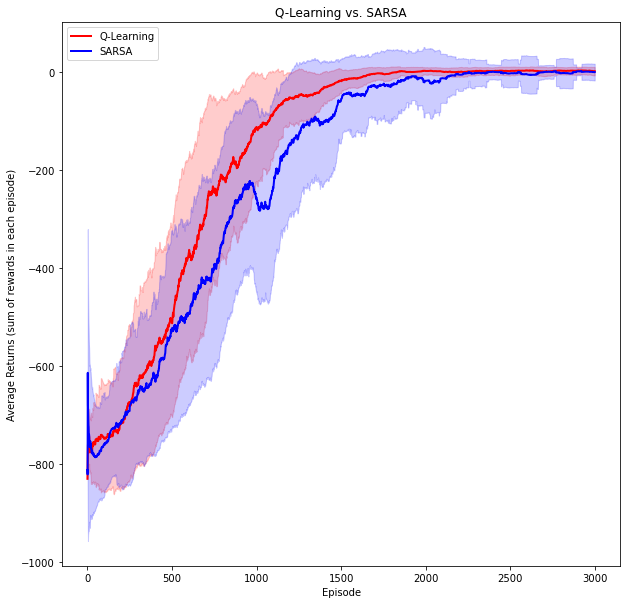

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
axes.set_title("Q-Learning vs. SARSA")
axes.set_xlabel("Episode")
axes.set_ylabel("Average Returns (sum of rewards in each episode)")

axes.plot(list(range(len(avg_returns_qlearning))),avg_returns_qlearning, color="red", linewidth=2)
axes.fill_between(list(range(len(returns))),
                  np.array(avg_returns_qlearning)+np.array(stds_qlearning),
                  np.array(avg_returns_qlearning)-np.array(stds_qlearning),
                  color="red", alpha=0.2)

axes.plot(list(range(len(avg_returns_sarsa))),avg_returns_sarsa, color="blue", linewidth=2)
axes.fill_between(list(range(len(returns))),
                  np.array(avg_returns_sarsa)+np.array(stds_sarsa),
                  np.array(avg_returns_sarsa)-np.array(stds_sarsa),
                  color="blue", alpha=0.2)

axes.legend(["Q-Learning", "SARSA"], loc='upper left')
plt.show()

## Extra Questions (do them in your own time)

*Q2 (programming): Study the Expected SARSA algorithm \[[Sutton2018, 6.6](http://incompleteideas.net/book/the-book-2nd.html)\], implement it and compare its performance in the Taxi environment with SARSA and Q-Learning.

*Q3 (programming): Study the doube Q-learning algorithm \[[Sutton2018, 6.7](http://incompleteideas.net/book/the-book-2nd.html)\], implement it and compare its performance in the Taxi environment with SARSA, Q-Learning and Expected SARSA.

<font size="1px">* = harder questions</font>

<font size="1px"><a href="https://www.linkedin.com/in/fredamouzgar/">Fred A.</a> Aug/2021</font>

<hr>